In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt # time series analysis
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
debug = True

sns.set()
%matplotlib inline

In [157]:
path = 'stock_sample.csv'
data = pd.read_csv(path, index_col = ['DATE'], parse_dates = ['DATE'])
data.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO\
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000,38.517220,39.606614,38.450681,39.398849,248000,NaN,0.0,1.0\
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300,38.617027,38.691882,38.375826,38.658613,131300,NaN,0.0,1.0\
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900,37.743715,38.708516,37.560735,38.600392,184900,NaN,0.0,1.0\
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000,18.860000,18.910000,18.870000,18.870000,10000,NaN,0.0,1.0\
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095,18.860000,18.890000,18.790000,18.810000,39095,NaN,0.0,1.0\
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468,18.580000,18.760000,18.580000,18.740000,17468,NaN,0.0,1.0\
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384,18.520000,18.520000,18.301200,18.490000,22384,NaN,0.0,1.0\
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633,18.470000,18.678000,18.470000,18.650000,22633,NaN,0.0,1.0\
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412,18.510000,18.510000,18.150000,18.256200,67412,NaN,0.0,1.0\


### Data Cleansing

In [158]:
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']

drop_Cols = ['FIGI', 'TYPE', 'FREQUENCY', 'ADJ_OPEN', 'ADJ_HIGH', 'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME', 'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO\\']

data = data.drop(drop_Cols, axis = 1)

data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100,39095
2018-06-01,GF,18.58,18.760,18.5800,18.7400,17468
2018-05-31,GF,18.52,18.520,18.3012,18.4900,22384
2018-05-30,GF,18.47,18.678,18.4700,18.6500,22633
2018-05-29,GF,18.51,18.510,18.1500,18.2562,67412


In [159]:
data.info

<bound method DataFrame.info of            TICKER   OPEN     HIGH      LOW    CLOSE  VOLUME
DATE                                                       
2018-06-04     GF  18.86  18.8900  18.7900  18.8100   39095
2018-06-01     GF  18.58  18.7600  18.5800  18.7400   17468
2018-05-31     GF  18.52  18.5200  18.3012  18.4900   22384
2018-05-30     GF  18.47  18.6780  18.4700  18.6500   22633
2018-05-29     GF  18.51  18.5100  18.1500  18.2562   67412
...           ...    ...      ...      ...      ...     ...
2014-06-27     GF  18.63  18.6300  18.5100  18.6100   28400
2014-06-26     GF  18.52  18.5901  18.4200  18.5300   60000
2014-06-25     GF  18.66  18.7200  18.5900  18.6000  171700
2014-06-24     GF  18.91  18.9500  18.8300  18.8300   35200
2014-06-23     GF  19.05  19.0500  18.9500  18.9500   34300

[995 rows x 6 columns]>

### Plot Stock Price (2014 ~ 2018)

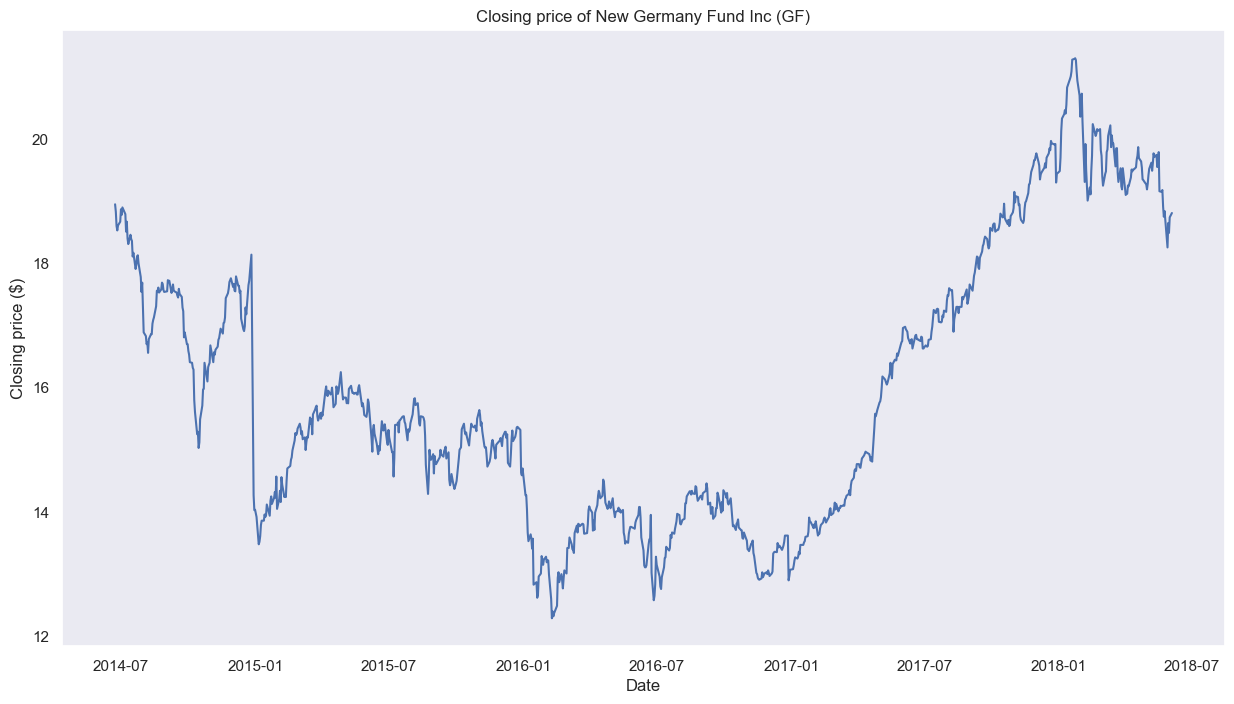

In [160]:
plt.figure(figsize = (15, 8))
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.xlabel('Date')
plt.ylabel('Closing price ($)')
plt.grid(False)
plt.show()

### Moving Average

In [161]:
def plot_moving_average(series, window, plot_interval = False, scale = 1.96):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None

    try:
        if not isinstance(window, int):
            raise TypeError('\'window\' must be an Integer')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(plot_interval, bool):
            raise TypeError('\'plot_interval\' must be a Boolean')
    except TypeError as e:
        print('Error: ', e)
        return None

    rolling_mean = series.rolling(window = window).mean()

    plt.figure(figsize = (15, 8))
    plt.title(f'Moving average\nwindow size = {window}')
    plt.plot(rolling_mean, 'g', label = 'Rolling mean trend')

    if plot_interval:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        low_bound = rolling_mean - (mae + scale * deviation)
        up_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(up_bound, 'r--', label = 'Upper/Lower bounds')
        plt.plot(low_bound, 'r--')

    plt.plot(series[window:], label = 'Actual value')
    plt.legend(loc = 'best')

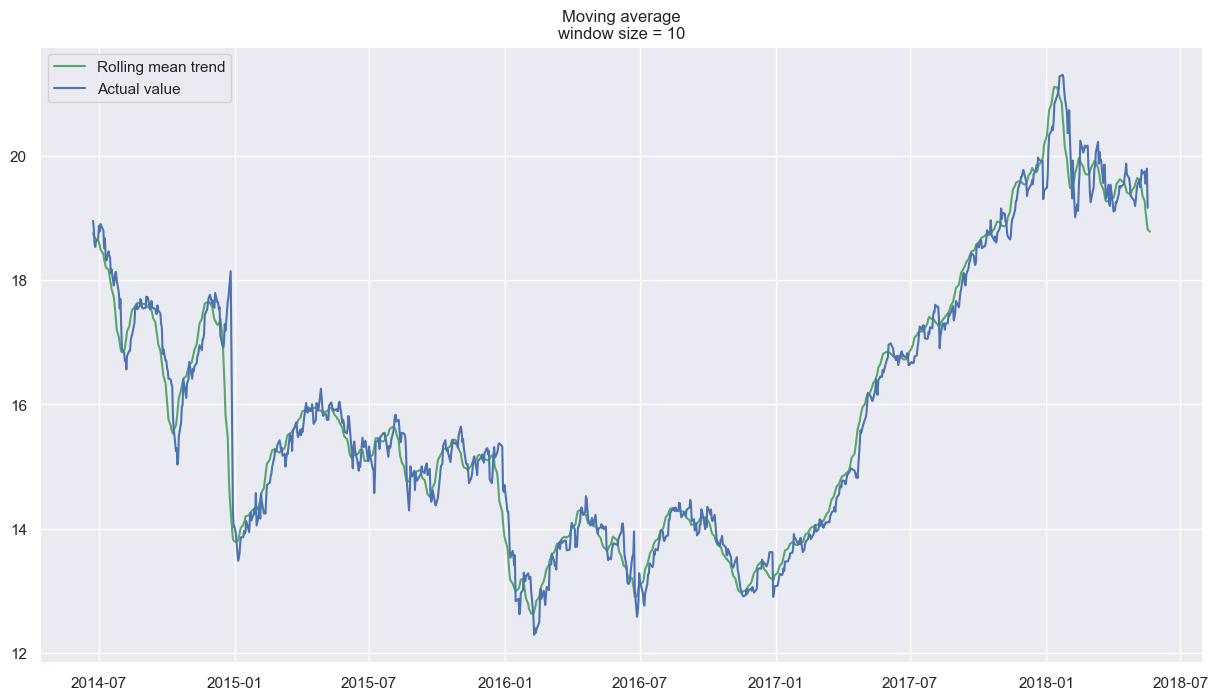

In [162]:
# 10-day moving average
plot_moving_average(data.CLOSE, 10)

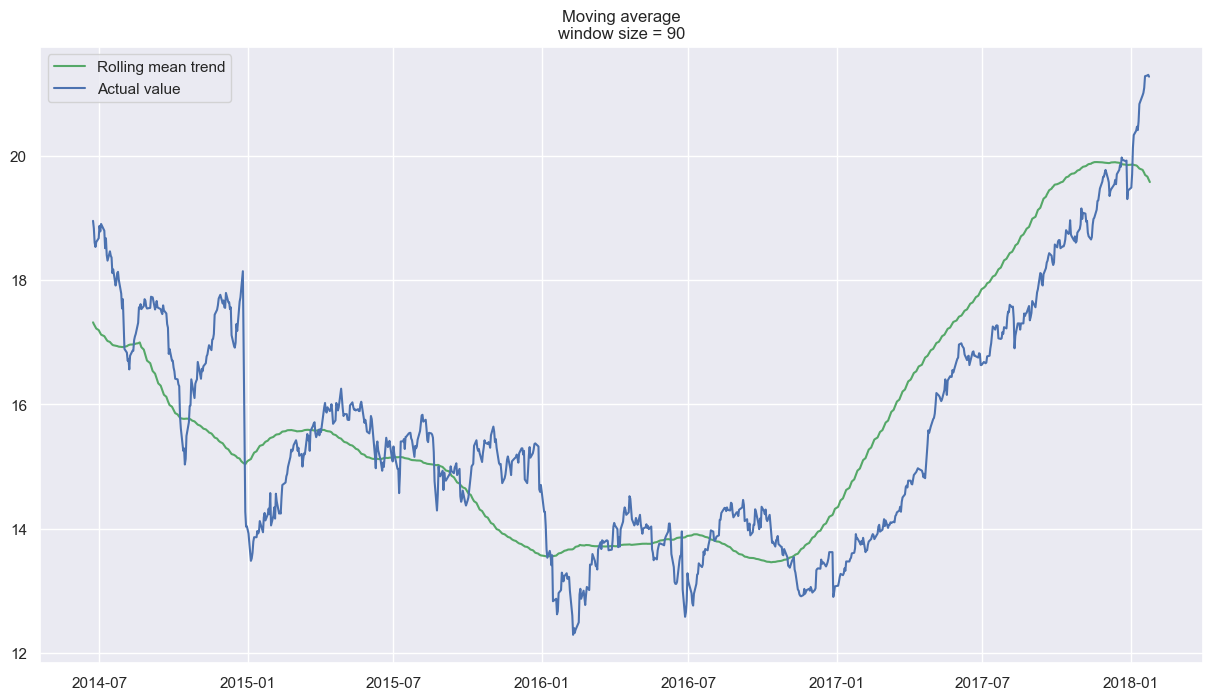

In [163]:
# 90-day moving average
plot_moving_average(data.CLOSE, 90)

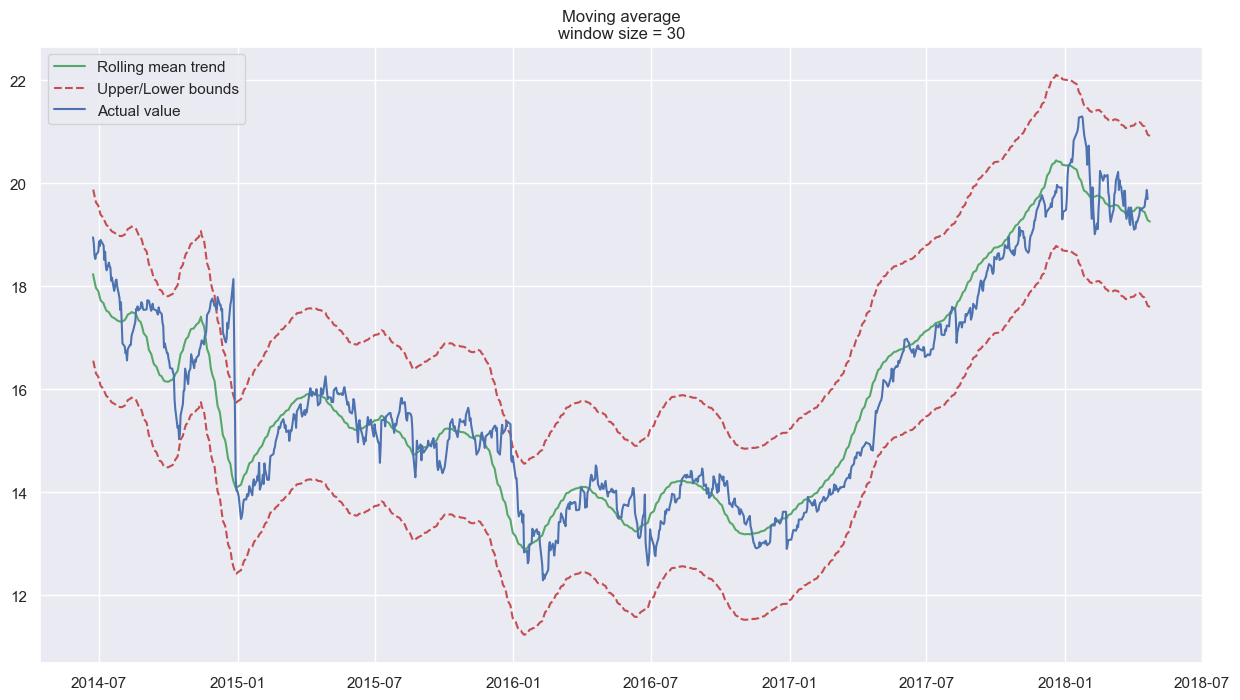

In [164]:
# 30-day moving average with deviation intervals
plot_moving_average(data.CLOSE, 30, True)

### Exponential Smoothing
$y = \alpha x_{t} + (1 - \alpha) y_{t-1} , \ where \ t > 0$

In [165]:
def expo_smoothing(series, alpha):
    try:
        if not isinstance(alpha, float):
            raise TypeError('\'alpha\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    if alpha <= 0 or alpha >= 1:
        raise Exception('\'alpha\' must be in the range of 0 to 1')

    result = [series[0]]
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return result[::-1]

def plot_expo_smoothing(series, alphas):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(alphas, list):
            raise TypeError('\'alphas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    plt.figure(figsize = (15, 8))
    plt.title('Exponential Smoothing')
    for alpha in alphas:
        plt.plot(expo_smoothing(series, alpha), label = f'Alpha = {alpha}')
    plt.plot(series.values[::-1], 'c', label = 'Actual')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.grid(True)

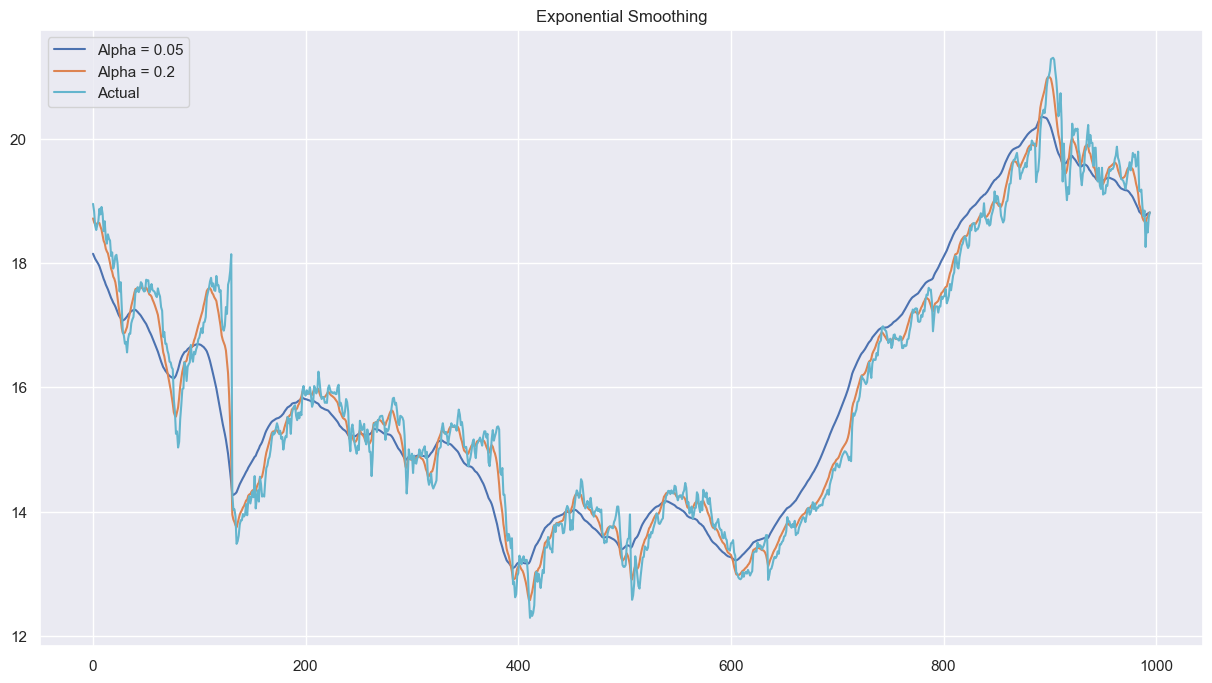

In [166]:
# plot exponential smoothing
plot_expo_smoothing(data.CLOSE, [0.05, 0.2])

### Double Exponential Smoothing
$y = \alpha x_{t} + (1 - \alpha) (y_{t-1} + b_{t-1})$ <br>
$b_{t} = \beta (y_{t} - y_{t-1}) + (1 - \beta) b_{t-1}$

In [167]:
def double_expo_smoothing(series, alpha, beta):
    try:
        if not isinstance(alpha, float):
            raise TypeError('\'alpha\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(beta, float):
            raise TypeError('\'beta\' must be a Float')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    if alpha <= 0 or alpha >= 1:
        raise Exception('\'alpha\' must be in the range of 0 to 1')
    if beta <= 0 or beta >= 1:
        raise Exception('\'beta\' must be in the range of 0 to 1')

    result = [series[0]]
    for i in range(1, len(series) + 1):
        if i == 1:
            y, b = series[0], series[1] - series[0]
        if i >= len(series):
            x = result[-1]
        else:
            x = series[i]
        
        y_last, y = y, alpha * x + (1 - alpha) * (y + b)
        b = beta * (y - y_last) + (1 - beta) * b
        result.append(y + b)
    
    return result[::-1]

def plot_double_expo_smoothing(series, alphas, betas):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(alphas, list):
            raise TypeError('\'alphas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    try:
        if not isinstance(betas, list):
            raise TypeError('\'betas\' must be a List')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    plt.figure(figsize = (15, 8))
    plt.title('Double Exponential Smoothing')
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_expo_smoothing(series, alpha, beta), label = f'Alpha = {alpha}, Beta = {beta}')
    plt.plot(series.values[::-1], 'c', label = 'Actual')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.grid(True)

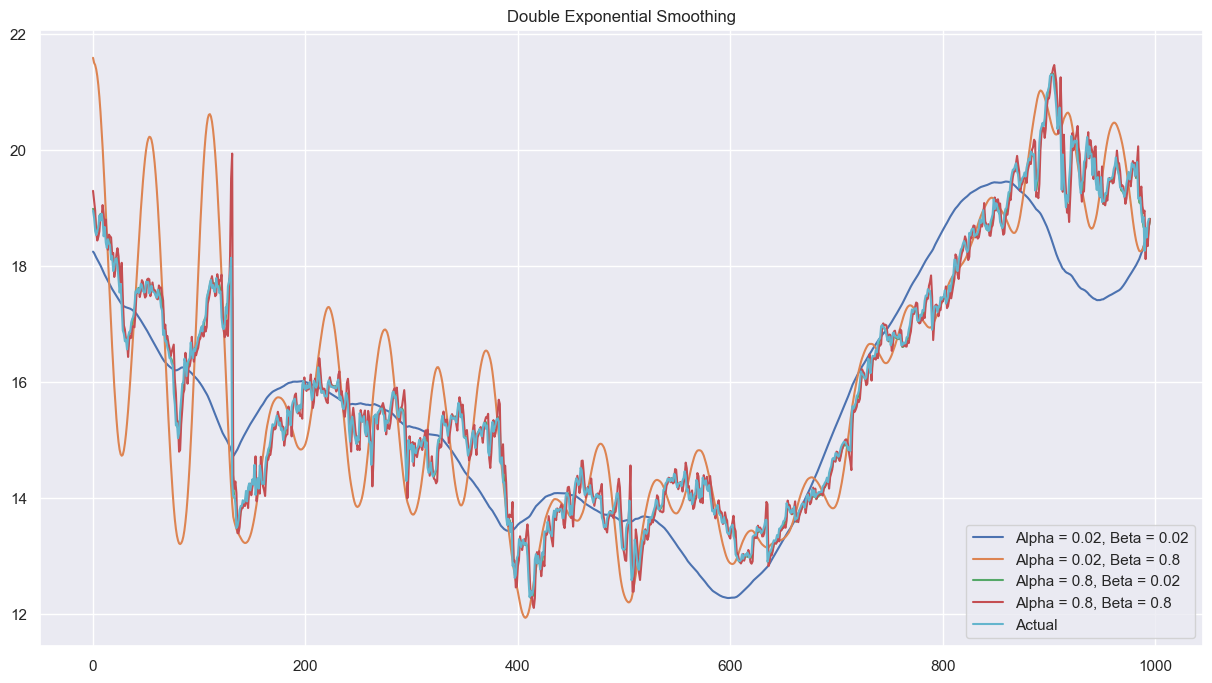

In [168]:
plot_double_expo_smoothing(data.CLOSE, alphas = [0.02, 0.8], betas = [0.02, 0.8])

### Modeling: Turning Series into Stationary Process

In [169]:
def plot_time_series(series, lags = None):
    try:
        if not isinstance(series, pd.Series):
            raise TypeError('\'series\' must be a Pandas Series')
    except TypeError as e:
        print('Error: ', e)
        return None
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = (12, 8))
        layout = (2, 2)
        series_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0)) # Autocorrelation plot
        pacf_ax = plt.subplot2grid(layout, (1, 1)) # Partial Autocorrelation plot

        series.plot(ax = series_ax)
        p_value = round(sm.tsa.stattools.adfuller(series)[1], 5)
        series_ax.set_title(f'Time Series Analysis Plots\nDickey-Fuller: p = {p_value}')
        smt.graphics.plot_acf(series, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(series, lags = lags, ax = pacf_ax, method = 'ywm')
        plt.tight_layout()

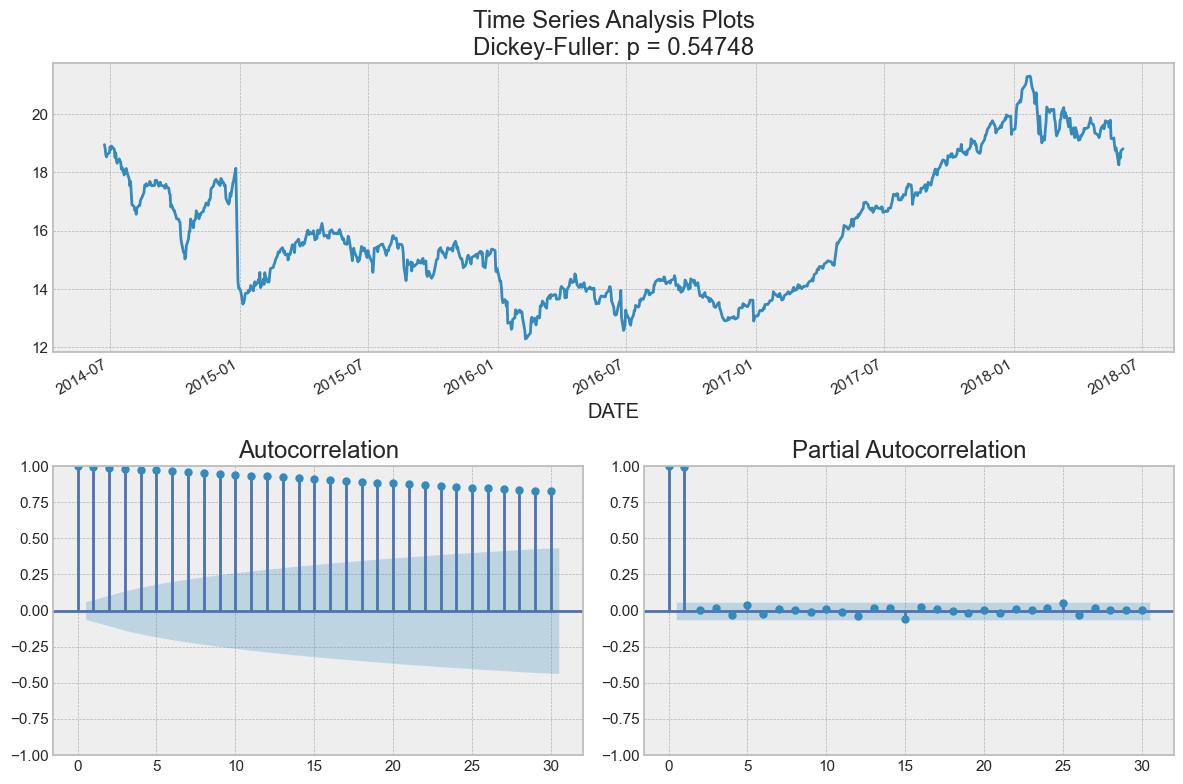

In [170]:
plot_time_series(data.CLOSE, 30)

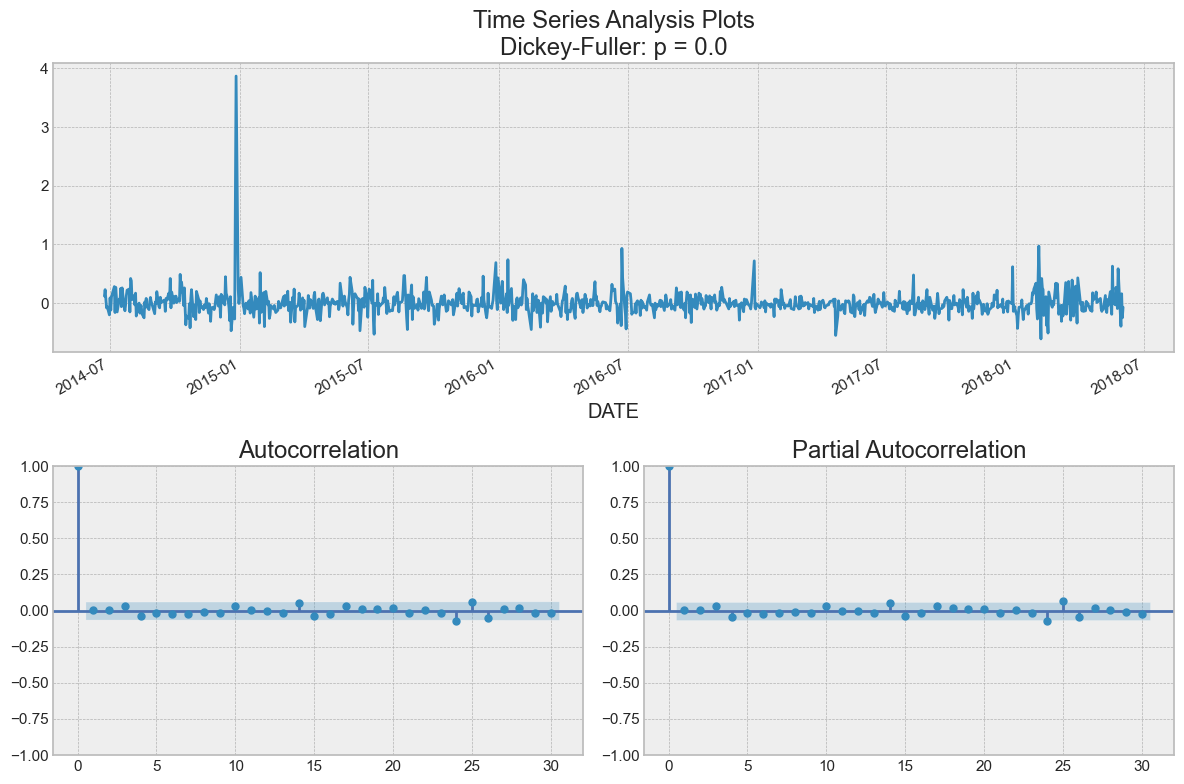

In [171]:
# take daily return instead of price level
day_return = data.CLOSE - data.CLOSE.shift(1)
plot_time_series(day_return[1:], 30)
# from plots we can see daily return is indeed stationary process

### SARIMA (Seasonal Autoregressive Integrated Moving Average Model)
$SARIMA(p, d, q)(P, D, Q, s)$

In [172]:
x = 4
# AR model parameters
ps = range(0, x)
d = 1
qs = range(0, x)

# MA model parameters
Ps = range(0, x)
D = 1
Qs = range(0, x)
s = 5

# list of possible parameter combinations
params = []
for i in ps:
    for j in qs:
        for k in Ps:
            for l in Qs:
                params.append((i, j, k, l))
len(params)

256

In [173]:
def optimize_SARIMA(params_list, d, D, s, series, day = 5):
    """
    Choose best model according to AIC
    
    - params_list : list of (p, q, P, Q) tuples
    - d : non-seasonal difference
    - D : seasonal difference
    - s : length of season
    """

    result = []
    
    train = series[day:]
    train = train[::-1]

    pbar = tqdm(params_list, disable = not debug)
    for param in pbar:
        pbar.set_description(f'Processing {param}')
        try:
            model = sm.tsa.statespace.SARIMAX(
                train, 
                order = (param[0], d, param[1]), 
                seasonal_order = (param[2], D, param[3], s)
            ).fit(disp = False)
        except:
            continue
            
        result.append([param, model.aic])

    result_df = pd.DataFrame(result, columns = ['(p, q, P, Q)', 'AIC'])
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return result_df

In [174]:
result_df = optimize_SARIMA(params, d, D, s, data.CLOSE)

  0%|          | 0/256 [00:00<?, ?it/s]

In [175]:
result_df

,"(p, q, P, Q)",AIC
0,"(0, 0, 2, 3)",-290.364521
1,"(0, 0, 0, 1)",-289.793324
2,"(0, 0, 3, 3)",-289.558701
3,"(0, 1, 2, 3)",-288.653801
4,"(1, 0, 2, 3)",-288.649978
...,...,...
251,"(3, 0, 0, 0)",384.005869
252,"(2, 1, 0, 0)",385.669575
253,"(1, 2, 0, 0)",385.728984
254,"(3, 1, 0, 0)",385.937833


In [176]:
p, q, P, Q = result_df['(p, q, P, Q)'][0]

In [177]:
# forecast for 5 day horizon
horizon = 5
train_data = data.CLOSE[horizon:]
train_data = train_data[::-1]

In [178]:
best_model = sm.tsa.statespace.SARIMAX(
    train_data, 
    order = (p, d, q), 
    seasonal_order = (P, D, Q, s)
).fit(disp = False)

In [179]:
print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     CLOSE   No. Observations:                  990
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3], 5)   Log Likelihood                 151.182
Date:                                   Sat, 20 May 2023   AIC                           -290.365
Time:                                           00:45:19   BIC                           -261.015
Sample:                                                0   HQIC                          -279.201
                                                   - 990                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.9073      0.148     -6.142      0.000    

In [180]:
# more reasonable model SARIMA(1, 1, 1)(1, 0, 1, 5)
# based on visualization of acf and pacf
model = sm.tsa.statespace.SARIMAX(
    train_data, 
    order = (1, 1, 1), 
    seasonal_order = (1, 0, 1, 5)
).fit(disp = False)

In [181]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             CLOSE   No. Observations:                  990
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood                 162.216
Date:                           Sat, 20 May 2023   AIC                           -314.433
Time:                                   00:45:20   BIC                           -289.950
Sample:                                        0   HQIC                          -305.123
                                           - 990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0147      3.550     -0.004      0.997      -6.972       6.943
ma.L1          0.0260      3.547      0.007

### Predict Price for next five trading days

In [182]:
def plot_prediction(series, model, day = 5):
    """
    Plot actual close price vs predicted value
    """
    series = series[::-1]
    n = series.shape[0]
    
    # predict for latest five trading day
    predicted_val = model.predict(start = n - day, end = n - 1)

    # assign date to predicted
    predicted_val.index = series.index[n - day :]

    # mean absolute percentage error
    error = np.mean(np.abs((series[n - day :] - predicted_val) / series[n - day :])) * 100
    error = round(error, 2)

    plt.figure(figsize = (15, 8))
    plt.title(f'Predicted price for next {day} trading days\nMean absolute percentage error: {error}%')
    plt.plot(series[n - (day + 15) : ], 'b', label = 'Actual') # visual actual price and price of previous 15 trading days
    plt.plot(predicted_val, 'r', label = 'Prediction')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.grid(True)

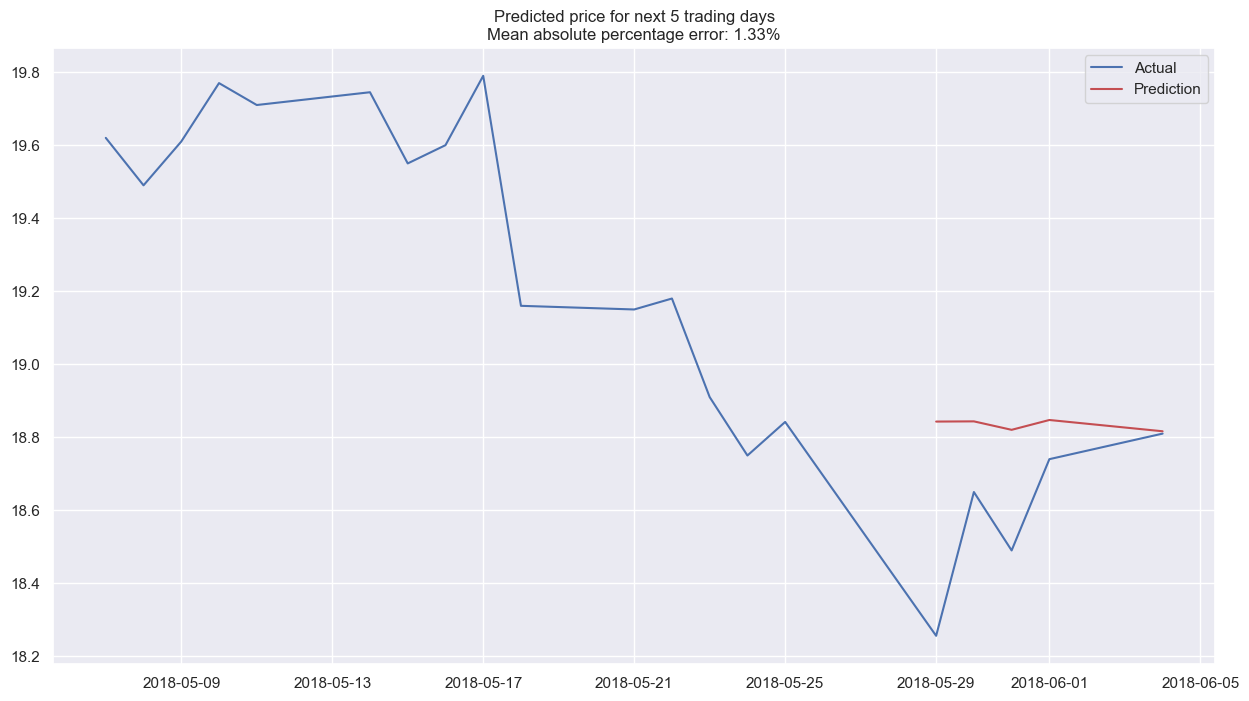

In [185]:
# prediction for optimized model
plot_prediction(data.CLOSE, best_model, horizon)

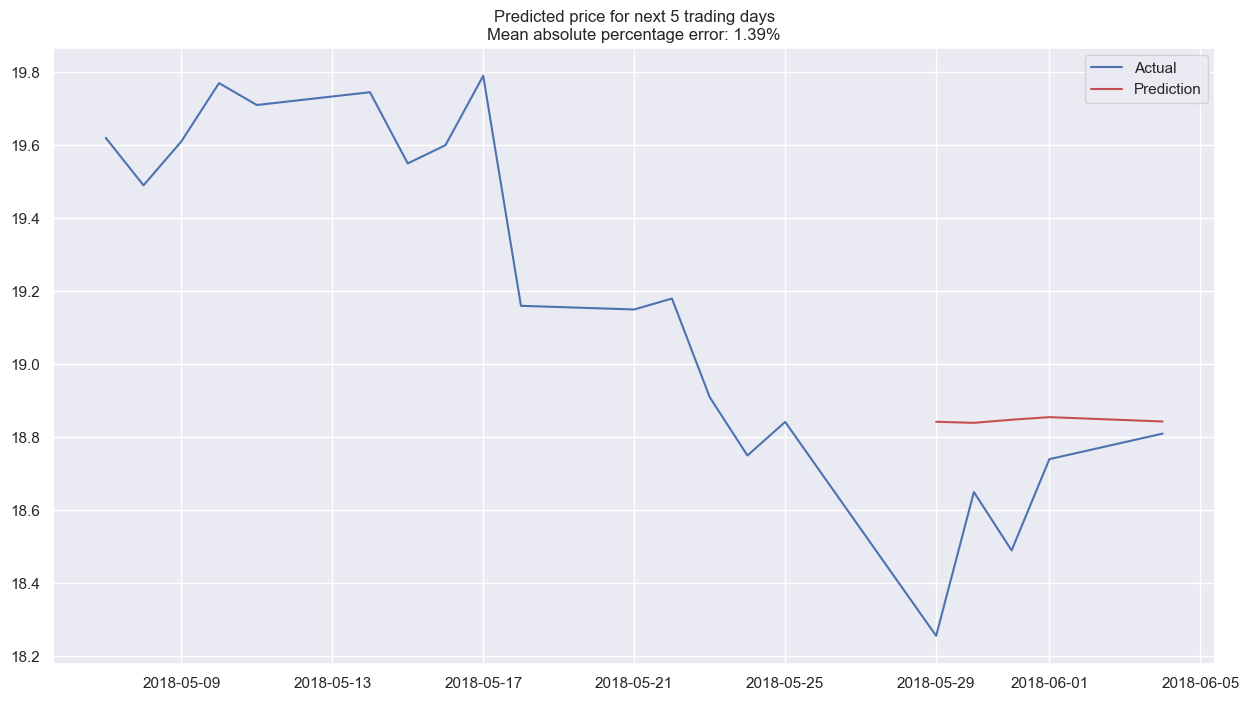

In [186]:
# prediction for more reasonal model
plot_prediction(data.CLOSE, model, horizon)